In [80]:
import re
import requests
import pandas as pd
import json
import config
import warnings
warnings.filterwarnings("ignore")

from elasticsearch import Elasticsearch

## Helper

In [2]:
def divider(n=1):
    for i in range(n):
        print("-" * 20)

def full(df):
    """
    display the full pandas dataframe
    """
    with pd.option_context("display.max_rows", None):
        display(df)

## load data from ES

In [3]:
user_name, pw = config.ES_USERNAME, config.ES_PASSWORD

In [4]:
# Connect to Elasticsearch
es = Elasticsearch("https://127.0.0.1:9200", basic_auth=(user_name, pw), verify_certs=False)

# check the index list
indices = es.cat.indices(index='*', h='index', format='json')

In [5]:
for index in indices:
    print(index)

{'index': 'rent'}
{'index': 'family_and_community_2011_2016'}
{'index': 'economy_and_industry_2014-2019'}
{'index': 'twitter_data'}
{'index': 'property_price'}
{'index': 'income'}
{'index': '2021_lga_settlement_reports_permanent_settlers_by_migration_stream'}
{'index': 'mortgage'}
{'index': 'building_approvals2011-2020'}
{'index': 'selected_medians_and_averages_2011_2016_2021'}
{'index': 'observations'}
{'index': 'housing_price'}
{'index': 'students'}
{'index': 'visa'}
{'index': 'income_2014-2019'}
{'index': 'migration'}
{'index': 'immigration'}
{'index': 'as4_median_housing_price2010_2014'}
{'index': 'rental_price'}
{'index': 'studying'}


In [6]:
# loading all the data
raw_data = {}

def contain_region(vars_: list):
    for var in vars_:
        var = var.lower()
        if "lga" in var or "sa4" in var:
            return True
    return False

for item in indices:
    query = {
        "query": {
            "match_all": {}
        }
    }
    index_ = item['index']
    print(f"retrieving index {index_}")
    # Grab the exact size of the dataset, elasticSearch default only returns 10
    temp_response = es.search(index=index_, body=query)
    
    # only grabbing sudo data
    try:
        vars_ = temp_response['hits']['hits'][0]['_source']
    except IndexError:
        print("no data in the index, aborting...")
        divider()
        continue
    if not contain_region(vars_): 
        print("not an sudo index, aborting...")
        divider()
        continue
    
    index_size = temp_response['hits']['total']['value']

    # Retrieve the full dataset
    full_response = es.search(
        index=index_, 
        body=query,
        size=index_size
    )

    raw_data[index_] = full_response['hits']['hits']

    divider()

retrieving index rent
not an sudo index, aborting...
--------------------
retrieving index family_and_community_2011_2016
--------------------
retrieving index economy_and_industry_2014-2019
--------------------
retrieving index twitter_data
not an sudo index, aborting...
--------------------
retrieving index property_price
not an sudo index, aborting...
--------------------
retrieving index income
not an sudo index, aborting...
--------------------
retrieving index 2021_lga_settlement_reports_permanent_settlers_by_migration_stream
--------------------
retrieving index mortgage
not an sudo index, aborting...
--------------------
retrieving index building_approvals2011-2020
--------------------
retrieving index selected_medians_and_averages_2011_2016_2021
--------------------
retrieving index observations
not an sudo index, aborting...
--------------------
retrieving index housing_price
not an sudo index, aborting...
--------------------
retrieving index students
not an sudo index, abor

In [7]:
assert len(raw_data) == 7, "There should be 7 SUDO datasets"

## Transform data into table form and put into pandas dataframe for easier analysis

In [8]:
raw_data.keys()

dict_keys(['family_and_community_2011_2016', 'economy_and_industry_2014-2019', '2021_lga_settlement_reports_permanent_settlers_by_migration_stream', 'building_approvals2011-2020', 'selected_medians_and_averages_2011_2016_2021', 'income_2014-2019', 'as4_median_housing_price2010_2014'])

In [9]:
all_sudo_data = {}

for index, raw_data_ in raw_data.items():
    raw_data_ = [item['_source'] for item in raw_data_]
    all_sudo_data[index] = raw_data_

df_sudo_data = {}
for index, data_ in all_sudo_data.items():
    df_sudo_data[index] = pd.DataFrame(data_)

In [10]:
df_sudo_data.keys()

dict_keys(['family_and_community_2011_2016', 'economy_and_industry_2014-2019', '2021_lga_settlement_reports_permanent_settlers_by_migration_stream', 'building_approvals2011-2020', 'selected_medians_and_averages_2011_2016_2021', 'income_2014-2019', 'as4_median_housing_price2010_2014'])

In [11]:
# decode col names:
var_definitions = {}

data_definitions = get_ipython().getoutput('ls ./data_definition')

for data_definition in data_definitions:
    with open('./data_definition/' + data_definition, 'r') as f:
        temp_file = json.load(f)
        vars_ = temp_file['selectedAttributes']
        for var_ in vars_:
            var_definitions[var_['name']] = var_['title']

In [12]:
# Renaming cols to meaningful names
for index, df_ in df_sudo_data.items():
    columns = df_.columns.to_list()
    columns = [var_definitions[item.strip()] for item in columns]
    df_.columns = columns

In [13]:
# Check if year and SA4 code is in the columns, which are the two key variables

for index, df_ in df_sudo_data.items():
    print(index)
    print(f"Year in columns: {'Year' in df_.columns}")
    print(f"SA4 Code in columns: {'SA4 Code' in df_.columns}")
    divider()

family_and_community_2011_2016
Year in columns: True
SA4 Code in columns: True
--------------------
economy_and_industry_2014-2019
Year in columns: True
SA4 Code in columns: True
--------------------
2021_lga_settlement_reports_permanent_settlers_by_migration_stream
Year in columns: False
SA4 Code in columns: False
--------------------
building_approvals2011-2020
Year in columns: True
SA4 Code in columns: False
--------------------
selected_medians_and_averages_2011_2016_2021
Year in columns: True
SA4 Code in columns: True
--------------------
income_2014-2019
Year in columns: True
SA4 Code in columns: True
--------------------
as4_median_housing_price2010_2014
Year in columns: True
SA4 Code in columns: False
--------------------


In [14]:
# making up year or SA4 code, because they are used as index to join the dataframes
df_sudo_data['2021_lga_settlement_reports_permanent_settlers_by_migration_stream']['Year'] = 2020
df_sudo_data['building_approvals2011-2020'].rename(columns={'SA4 Code 2011': 'SA4 Code'}, inplace=True)
df_sudo_data['as4_median_housing_price2010_2014'].rename(columns={'SA4 Code 2011': 'SA4 Code'}, inplace=True)

In [14]:
df_sudo_data['as4_median_housing_price2010_2014'].columns

Index(['SA4 Code',
       'Residential Property Median Attached Dwelling Sale Price ($)',
       'Residential Property Number of House Transfers',
       'Residential Property Number of Attached Dwelling Transfers', 'Year',
       'Residential Property Median House Sale Price ($)', 'SA4 Name 2011'],
      dtype='object')

In [23]:
for index, df_ in df_sudo_data.items():
    print(index)
    print(df_['Year'].value_counts(dropna=False))

family_and_community_2011_2016
Year
2011    89
2016    89
Name: count, dtype: int64
economy_and_industry_2014-2019
Year
2014    89
2015    89
2016    89
2017    89
2018    89
2019    89
Name: count, dtype: int64
2021_lga_settlement_reports_permanent_settlers_by_migration_stream
Year
2020    451
Name: count, dtype: int64
building_approvals2011-2020
Year
2015    88
2016    88
2017    88
2018    88
2019    88
2020    88
2011    87
2012    87
2013    87
2014    87
Name: count, dtype: int64
selected_medians_and_averages_2011_2016_2021
Year
2016    89
2021    89
2011    88
Name: count, dtype: int64
income_2014-2019
Year
2014    89
2015    89
2016    89
2017    89
2018    89
2019    89
Name: count, dtype: int64
as4_median_housing_price2010_2014
Year
2013    88
Name: count, dtype: int64


In [15]:
# Concatenate all the dataframes along the rows
# have to leave 2021 lga settlement data here because it's using a different partitioning system than the others: LGA

dfs = [df.set_index(['Year', 'SA4 Code']) for index, df in df_sudo_data.items() if index != '2021_lga_settlement_reports_permanent_settlers_by_migration_stream']
df_sudo = pd.concat(dfs, axis=0, join='outer')

df_sudo = df_sudo.sort_index(level=['Year', 'SA4 Code'])

In [16]:
df_sudo = df_sudo.groupby(level=[0, 1]).first()

In [17]:
df_sudo

Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)  \
Year SA4 Code                                                                                                                 
2011 101                                                     8.3                                                              
     102                                                    11.5                                                              
     103                                                     7.9                                                              
     104                                                    13.0                                                              
     105                                                     6.8                                                              
...                                                          ...                                                              
2021 604                                                     NaN                                                              
     701                                                     NaN                                                              
     702                                                     NaN                                                              
     801                                                     NaN                                                              
     901                                                     NaN                                                              

               Household Stress - Census Households where rent payments are less than 30% of household income (%)  \
Year SA4 Code                                                                                                       
2011 101                                                    91.7                                                    
     102                                                    88.5                                                    
     103                                                    92.1                                                    
     104                                                    87.0                                                    
     105                                                    93.2                                                    
...                                                          ...                                                    
2021 604                                                     NaN                                                    
     701                                                     NaN                                                    
     702                                                     NaN                                                    
     801                                                     NaN                                                    
     901                                                     NaN                                                    

              Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)  \
Year SA4 Code                                                                                                 
2011 101                                                    null                                              
     102                                                    null                                              
     103                                                    null                                              
     104                                                    null                                              
     105                                                    null                                              
...                                                          ...

In [18]:
df_sudo.shape

(977, 56)

In [19]:
df_sudo.reset_index(inplace=True)

In [20]:
df_sudo['State and Territory Id'] = df_sudo['SA4 Code'].apply(lambda x: x//100)

In [21]:
# Deleting columns with duplicate information such as complements
df_sudo = df_sudo.drop([
    'Household Stress - Census Households where rent payments are less than 30% of household income (%)',
    'Household Stress - Census Households where mortgage repayments are less than 30% of household income (%)',
    'Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)',
    'Housing Suitability - Occupied private dwellings - Census Dwellings with no bedrooms needed or spare (no.)',
    'Value of Total Buildings ($000)',
    'Value of Non-Residential Building ($000)',
    'Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)',
    'Housing Suitability - Occupied private dwellings - Census Dwellings with no bedrooms needed or spare (no.)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $1-$499 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $500-$999 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $1000-$1999 per week (%)', 
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $2000-$2999 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $3000 or more per week (%)',  
],
    axis=1,
    errors='ignore'
)

In [22]:
df_sudo = df_sudo.replace('null', pd.NA)
df_sudo = df_sudo.replace('None', pd.NA)

In [23]:
# Combine economy_and_industry_2014-2019's house price with 
# economy_and_industry_2014-2019's house price

## House
df_sudo['House Median Sales Price'] = \
    df_sudo['Residential Property Prices - Year ended 30 June Houses - median sale price ($)'].combine_first(
        df_sudo['Residential Property Median House Sale Price ($)']
    )
df_sudo['House No of Transactions'] = \
    df_sudo['Residential Property Prices - Year ended 30 June Houses - number of transfers (no.)'].combine_first(
        df_sudo['Residential Property Number of House Transfers']
    )

## Attached dwellings
df_sudo['Attached dwellings Median Sales Price'] = \
    df_sudo['Residential Property Prices - Year ended 30 June Attached Dwellings - median sale price ($)']\
    .combine_first(
        df_sudo['Residential Property Median Attached Dwelling Sale Price ($)']
    )
df_sudo['Attached dwellings No of Transactions'] = \
    df_sudo['Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)']\
    .combine_first(
        df_sudo['Residential Property Number of Attached Dwelling Transfers']
    )

df_sudo = df_sudo.drop(
    [
        'Residential Property Prices - Year ended 30 June Houses - median sale price ($)',
        'Residential Property Median House Sale Price ($)',
        'Residential Property Prices - Year ended 30 June Houses - number of transfers (no.)',
        'Residential Property Number of House Transfers',
        'Residential Property Prices - Year ended 30 June Attached Dwellings - median sale price ($)',
        'Residential Property Median Attached Dwelling Sale Price ($)',
        'Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)',
        'Residential Property Number of Attached Dwelling Transfers'
    ],
    axis=1
)

In [24]:
# Converting data types
# Seems unnecessary once I converted 'null' to pd.NA, because null is causing pandas to render a lot of the 
# variables as object
# will leave it here incase I need it 

numeric_columns = [
    'Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)', 
    'Building Approvals - Year ended 30 June Value of residential building ($m)',
    'Building Approvals - Year ended 30 June Private sector dwellings excluding houses (no.)',
    'Building Approvals - Year ended 30 June Total private sector dwelling units (no.)',
    'Building Approvals - Year ended 30 June Total value of private sector dwelling units ($m)',
    'Building Approvals - Year ended 30 June Private sector houses (no.)',
    'Building Approvals - Year ended 30 June Total dwelling units (no.)',
    'Building Approvals - Year ended 30 June Value of private sector houses ($m)',
    'Building Approvals - Year ended 30 June Value of private sector dwellings excluding houses ($m)',
    'Estimates of Personal Income - Year ended 30 June Total income (excl. Government pensions and allowances) - Gini coefficient',
    'Estimates of Personal Income - Year ended 30 June Mean employee income ($)',
    'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers - Mean ($)',
    'Estimates of Personal Income - Year ended 30 June Mean investment income ($)',
    'Estimates of Personal Income - Year ended 30 June Median employee income ($)',
    'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers  - Median ($)',
    'Estimates of Personal Income - Year ended 30 June Median investment income ($)',
    'House Median Sales Price',
    'House No of Transactions',
    'Attached dwellings Median Sales Price',
    'Attached dwellings No of Transactions'
]

for column in numeric_columns:
    df_sudo[column] = pd.to_numeric(df_sudo[column], errors='coerce')

# df_sudo = df_sudo.astype(
#     {
#         'Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)': 'int64', 
#         'Building Approvals - Year ended 30 June Value of residential building ($m)': 'int64',
#         'Building Approvals - Year ended 30 June Private sector dwellings excluding houses (no.)': 'int64',
#         'Building Approvals - Year ended 30 June Total private sector dwelling units (no.)': 'int64',
#         'Building Approvals - Year ended 30 June Total value of private sector dwelling units ($m)': 'int64',
#         'Building Approvals - Year ended 30 June Private sector houses (no.)': 'int64',
#         'Building Approvals - Year ended 30 June Total dwelling units (no.)': 'int64',
#         'Building Approvals - Year ended 30 June Value of private sector houses ($m)': 'int64',
#         'Building Approvals - Year ended 30 June Value of private sector dwellings excluding houses ($m)': 'int64',
#         'Estimates of Personal Income - Year ended 30 June Total income (excl. Government pensions and allowances) - Gini coefficient': 'float64',
#         'Estimates of Personal Income - Year ended 30 June Mean employee income ($)': 'int64',
#         'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers - Mean ($)': 'int64',
#         'Estimates of Personal Income - Year ended 30 June Mean investment income ($)': 'int64',
#         'Estimates of Personal Income - Year ended 30 June Median employee income ($)': 'int64',
#         'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers  - Median ($)': 'int64',
#         'Estimates of Personal Income - Year ended 30 June Median investment income ($)': 'int64',
#         'State and Territory Id': 'category',
#         'House Median Sales Price': 'int64',
#         'House No of Transactions': 'int64',
#         'Attached dwellings Median Sales Price': 'int64',
#         'Attached dwellings No of Transactions': 'int64'
#     }, 
#     errors='ignore'
# )


In [25]:
df_sudo.dtypes

Year                                                                                                                              int64
SA4 Code                                                                                                                          int64
Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)                    float64
Rent and Mortgage Payments - Census Average monthly household mortgage payment ($)                                              float64
Rent and Mortgage Payments - Census Average monthly household rental payment ($)                                                float64
Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)                            float64
Household Stress - Census Households with mortgage repayments greater than or equal to 30% of household income (%)              float64
Building Approvals - Year ended 30 June Value of

In [26]:
df_sudo.shape

(977, 44)

# Data Analysis 

### EDA

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

In [28]:
STATE_TERRITORY_ID = {
    1: 'NSW',
    2: 'VIC',
    3: 'QLD',
    4: 'SA',
    5: 'WA',
    6: 'TAS',
    7: 'NT', # Northern Territory
    8: 'ACT' # Australian Capital Territory
}

In [54]:
MEL_SYD_SA4_NAME = [
    'Sydney - Outer South West',
    'Sydney - Inner West',
    'Sydney - Inner South West',
    'Sydney - Eastern Suburbs',
    'Sydney - City and Inner South',
    'Sydney - Blacktown',
    'Sydney - Baulkham Hills and Hawkesbury'
    'Sydney - Northern Beaches', 
    'Sydney - North Sydney and Hornsby',
    'Sydney - Outer West and Blue Mountains'
    'Sydney - Parramatta', 
    'Sydney - Sutherland', 
    'Sydney - South West',
    'Sydney - Ryde'
    'Melbourne - West', 
    'Melbourne - South East', 
    'Melbourne - Outer East',
    'Melbourne - North West',
    'Melbourne - North East',
    'Melbourne - Inner South', 
    'Melbourne - Inner East',
    'Melbourne - Inner',
]

MEL_SYD_SA4_NAME_TO_CODE = {}
MEL_SYD_SA4_CODE_TO_NAME = {}

In [55]:
for sa4 in MEL_SYD_SA4_NAME:
    try: 
        SA4_code = df_sudo[df_sudo['SA4 Name'] == sa4]['SA4 Code'].mode()[0]
        MEL_SYD_SA4_NAME_TO_CODE[sa4] = SA4_code
        MEL_SYD_SA4_CODE_TO_NAME[SA4_code] = sa4
    except: 
        continue

In [51]:
MEL_SYD_SA4_NAME_TO_CODE

{'Sydney - Outer South West': 123,
 'Sydney - Inner West': 120,
 'Sydney - Inner South West': 119,
 'Sydney - Eastern Suburbs': 118,
 'Sydney - City and Inner South': 117,
 'Sydney - Blacktown': 116,
 'Sydney - North Sydney and Hornsby': 121,
 'Sydney - Sutherland': 128,
 'Sydney - South West': 127,
 'Melbourne - South East': 212,
 'Melbourne - Outer East': 211,
 'Melbourne - North West': 210,
 'Melbourne - North East': 209,
 'Melbourne - Inner South': 208,
 'Melbourne - Inner East': 207,
 'Melbourne - Inner': 206}

In [32]:
df_sudo.to_csv('df_sudo.csv')

In [56]:
df_sudo_major = df_sudo[df_sudo.apply(lambda x: x['SA4 Code'] in MEL_SYD_SA4_NAME_TO_CODE.values(), axis=1)]

In [58]:
df_sudo_major['SA4 Name'] = df_sudo_major['SA4 Code'].apply(lambda x: MEL_SYD_SA4_CODE_TO_NAME[x])

In [60]:
df_sudo_major['SA4 Code'] = df_sudo_major['SA4 Code'].astype('category')

In [81]:
df_sudo_major['City'] = df_sudo_major['SA4 Name'].apply(
    lambda x: re.match('^([A-Z][a-z]+) - [A-Za-z ]+$', x)[1]
)

In [83]:
# df_sudo_major.to_csv('df_sudo_major.csv')

In [61]:
df_sudo_major.columns

Index(['Year', 'SA4 Code',
       'Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)',
       'Rent and Mortgage Payments - Census Average monthly household mortgage payment ($)',
       'Rent and Mortgage Payments - Census Average monthly household rental payment ($)',
       'Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)',
       'Household Stress - Census Households with mortgage repayments greater than or equal to 30% of household income (%)',
       'Building Approvals - Year ended 30 June Value of residential building ($m)',
       'Building Approvals - Year ended 30 June Private sector dwellings excluding houses (no.)',
       'Building Approvals - Year ended 30 June Total private sector dwelling units (no.)',
       'Building Approvals - Year ended 30 June Total value of private sector dwelling units ($m)',
       'Building Approvals - Year ended 30 June Private sec

In [32]:
# df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})

grouped_df = df_sudo.groupby(['Year', 'State and Territory Id']).\
    agg({
        'Attached dwellings No of Transactions': 'sum'
    })

In [ ]:
# df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})

grouped_df = df_sudo.groupby(['Year', 'State and Territory Id']).\
    agg({
        'Attached dwellings No of Transactions': 'sum',
        'Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)': 'sum'
    })

## Main Scenarios: housing/rental market

In [93]:
def get_IRR(start: int, end: int, var: str, df=df_sudo_major):
    filtered_df = df[df['Year'].isin([start, end])]
    pivot_df = filtered_df.pivot(index='SA4 Name', columns='Year', values=var)
    pivot_df['Rate of Change'] = ((pivot_df[end] / pivot_df[start]) ** (1/(end-start)) - 1) * 100

    ax = sns.barplot(
        data=pivot_df,
        x='Rate of Change',
        y='SA4 Name',
        hue='Rate of Change'
    )

    # Annotate each bar with the value from the data
    for p in ax.patches:  # loop through each bar
        width = p.get_width()  # get the width of the bar
        ax.text(
            width + 0.05,  # x-coordinate position of text
            p.get_y() + p.get_height() / 2,  # y-coordinate position of text
            '{:1.2f}'.format(width),  # text label
            va='center'  # center alignment
        )
    
    return pivot_df

### Response variable:
- average household monthly rent/mortgage payment (from family_community, only 2011, 2016)
- median price/# of transactions of house/attached dwellings: 2014 - 2019
- median weekly rent/mortgage: 2011, 2016, 2021

#### Median rent weekly

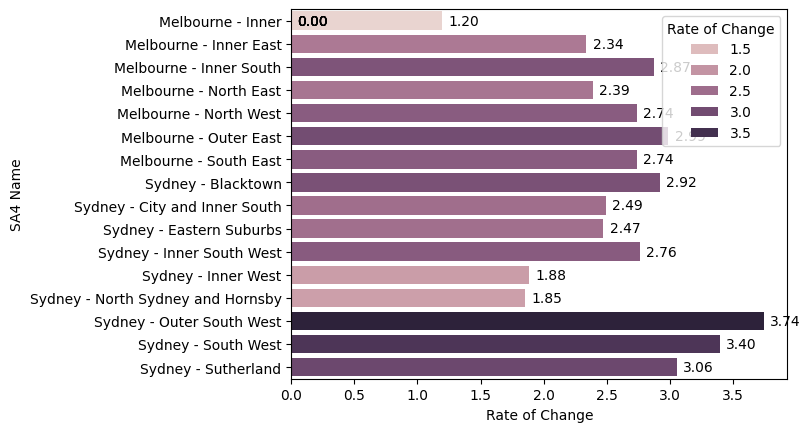

In [94]:
pivot_df = get_IRR(2011, 2021, 'Median rent weekly')

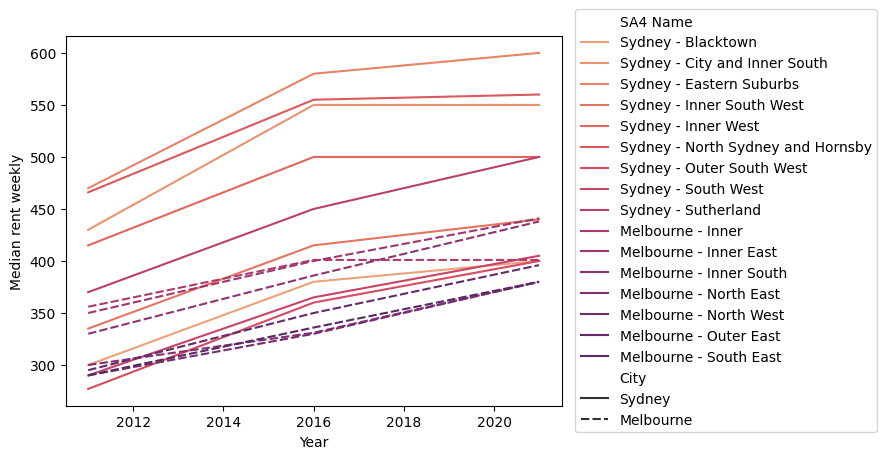

In [86]:
ax = sns.lineplot(
    data=df_sudo_major,
    x="Year",
    y='Median rent weekly',
    hue='SA4 Name',
    style='City',
    palette='flare'
)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.65, 0.5))

Rental payment (whether it reflects overall rental price or not) flats out during the period of 2016-2021 for Sydney.  
While the same continues its previous trend of growth in Melbourne. 

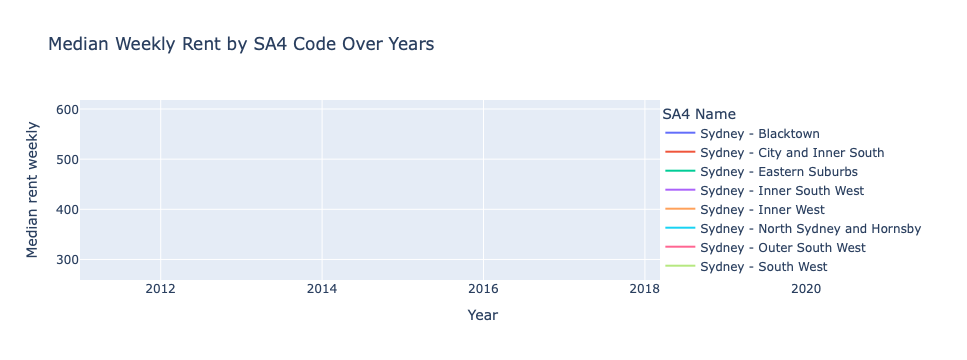

In [71]:
# Assuming df_sudo is already loaded and ready to use
fig = px.line(df_sudo_major, x="Year", y='Median rent weekly', color='SA4 Name', 
              title='Median Weekly Rent by SA4 Code Over Years')

# Moving the legend to the right of the plot and making it interactive
fig.update_layout(
    legend=dict(
        title='SA4 Name',
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=1.05
    )
)

fig.show()

#### Median mortgage payment weekly

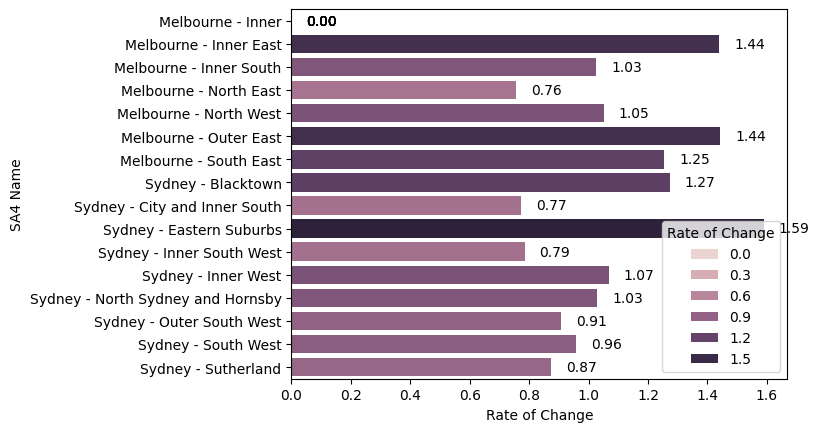

In [95]:
pivot_df = get_IRR(2011, 2021, 'Median mortgage repayment monthly')

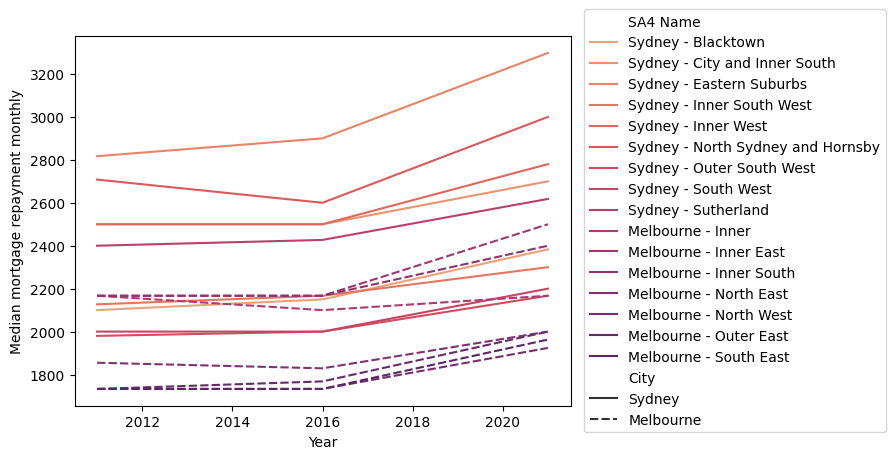

In [97]:
ax = sns.lineplot(
    data=df_sudo_major,
    x="Year",
    y='Median mortgage repayment monthly',
    hue='SA4 Name',
    palette='flare',
    style='City'
)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.65, 0.5))

In [77]:
!pwd

/Users/shengyangsun/github_local_repos/school/comp90024_assg2/frontend


![RBA_cash_rate](asset/RBA_cash_rate.png)

Mortgage payment climbs up between 2016 to 2021 despite the overall dropping of RBA cash rate.  
Most likely reason is the rapid increase of housing price.

#### House price and no of transactions

### Housing/rental market: Supply Side
- Building approvals:
    - #/value of private sector dwellings: houses and attached
    - public housing: implicit variable = total dwellings units #/value - private sector dwellings units #/value

### Housing/rental market: Demand Side

#### Internal
- Household stress: rent/mortgage payment % of household income: 2011, 2016
- Household suitability: extra rooms needed: 2011, 2016
- median/mean employee income
- median/mean capital gain
- median/mean investment income
- total income - gini coefficient

#### External
- immigration: only have 2020 data

## Scenarios: Other

### Income inbalance: Discrepencies between mean and median income, gini coefficient

### City expansion: new towns as predicted by the building approvals